In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import keras
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Activation,MaxPool2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
labels = ['no-plastic','plastic','metal']

In [ ]:
image_size = 224

X_train = []
y_train = []

# Function to apply enhancements to the images
# Function to apply enhancements to the images
def enhance_image(img):
    # Apply color correction (white balance adjustment)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Apply noise reduction (Gaussian blur)
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply sharpening (unsharp masking)
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    img = cv2.filter2D(img, -1, kernel)

    return img


# Loop through each label
for label in labels:
    # Load images from the train folder
    folderPath_train = os.path.join(r'/kaggle/input/sc307-mc/SOUVIK/', 'train', label)
    for filename in os.listdir(folderPath_train):
        img = cv2.imread(os.path.join(folderPath_train, filename))
        img = cv2.resize(img, (image_size, image_size))

        # Apply image enhancement
        img = enhance_image(img)

        # Append the image and label to the lists
        X_train.append(img)
        y_train.append(label)

    # Load images from the test folder
    folderPath_test = os.path.join(r'/kaggle/input/sc307-mc/SOUVIK/', 'test', label)
    for filename in os.listdir(folderPath_test):
        img = cv2.imread(os.path.join(folderPath_test, filename))
        img = cv2.resize(img, (image_size, image_size))

        # Apply image enhancement
        img = enhance_image(img)

        # Append the image and label to the lists
        X_train.append(img)
        y_train.append(label)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(2560, 224, 224, 3)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(2560, 224, 224, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=6,kernel_size=(5,5),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=16,kernel_size=(5,5),padding="same", activation="relu"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
# model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 224, 224, 6)       456       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 112, 112, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 16)      2416      
                                                                 
 activation_7 (Activation)   (None, 112, 112, 16)      0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 54, 54, 64)       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = '/kaggle/working/model_tumour.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True,
                             verbose = 1)

In [ ]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])
r=model.fit(X_train,y_train,validation_split=0.1, epochs = 100,steps_per_epoch=12, verbose=1, batch_size=30)

Epoch 1/100
12/12 [==============================] - 2s 49ms/step - loss: 83.4582 - accuracy: 0.3861 - val_loss: 1.2787 - val_accuracy: 0.5022
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 0.7993 - accuracy: 0.3833 - val_loss: 0.6244 - val_accuracy: 0.4675
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 0.6935 - accuracy: 0.4222 - val_loss: 0.6554 - val_accuracy: 0.4675
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 0.6857 - accuracy: 0.4556 - val_loss: 0.6839 - val_accuracy: 0.4459
Epoch 5/100
12/12 [==============================] - 0s 27ms/step - loss: 0.6875 - accuracy: 0.4278 - val_loss: 0.6840 - val_accuracy: 0.4589
Epoch 6/100
12/12 [==============================] - 0s 26ms/step - loss: 0.6845 - accuracy: 0.4805 - val_loss: 0.6775 - val_accuracy: 0.4545
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 0.6794 - accuracy: 0.4444 - val_loss: 0.6711 - val_accuracy: 0.4632
Epoch

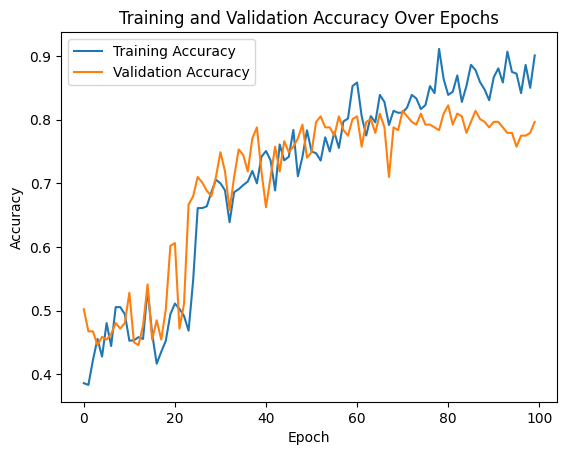

In [ ]:
history = r.history
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#### model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])
r=model.fit(X_train,y_train,validation_split=0.1, epochs = 100,steps_per_epoch=12, verbose=1, batch_size=30)


In [ ]:
train_dir = "/kaggle/input/sc307-mc/SOUVIK/train"
test_dir = "/kaggle/input/sc307-mc/SOUVIK/test"

In [ ]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224,224),
                                                                 label_mode = "categorical",
                                                                 batch_size = 32
                                                                 )
test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size =(224,224),
                                                               label_mode = "categorical",
                                                               batch_size = 32
                                                               )

Found 1926 files belonging to 3 classes.
Found 634 files belonging to 3 classes.


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

8/8 [==============================] - 0s 9ms/step


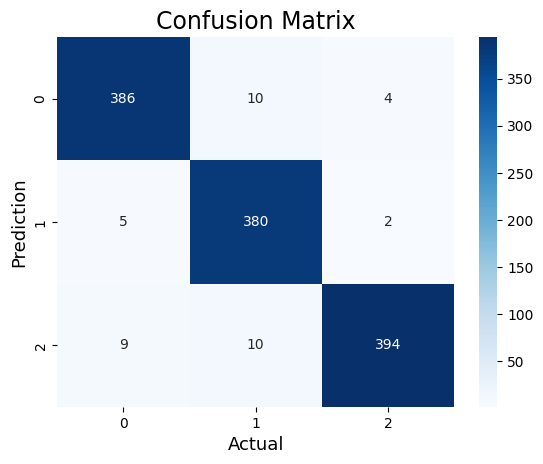

0.9666666666666667 [0.965, 0.95, 0.985] [0.965, 0.9819121447028424, 0.9539951573849879]


In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

# Create confusion matrix heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,cmap="Blues",
             alpha=0.7)

# Adding title to the heatmap
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)

# Save the heatmap as an image file
fig.savefig("Con.png")

# Display the heatmap
# plt.show()